In [1]:
import os
import numpy as np
from scipy.io import wavfile
from aubio import onset
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

from read_labels import read_labels

%matplotlib inline

In [2]:
filename = '/home/tracek/Data/Birdman/raw/STHELENA-02_20140605_200000_1_16k.wav'
sheets = read_labels('/home/tracek/Data/StHelena/sthelena_labels.xls')
sheet_selected = sheets['STHELENA-02_20140605_200000_1']

# in seconds [s]
sample_start_s = 30
sample_end_s = 95
min_duration_s = 0.300
max_duration_s = 0.750

win_s = 256 # samples
hop_s = win_s // 2

onset_detector = 'hfc' # other options: complex, phase, specdiff, kl, mkl, specflux, energy
onset_threshold = 0.01
onset_silence_threshold = -70

highpass_cut = 1000 # Hz

# if sample_start_s > win_s / sr:
#     sample_start_s -= win_s / sr

In [3]:
sr, signal = wavfile.read(filename)
signal_norm = signal.astype('float32') / 32767.0

In [4]:
def butter_highpass(highcut, fs, order=12):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a

b, a = butter_highpass(highpass_cut, sr, order=12)

In [5]:
onset_detector = onset(onset_detector, win_s, hop_s, sr)
onset_detector.set_threshold(onset_threshold)
onset_detector.set_silence(onset_silence_threshold)
onset_detector.set_minioi_s(min_duration_s)

In [6]:
condition = (sheet_selected['Time Start'] > sample_start_s) & (sheet_selected['Time End'] < sample_end_s)
sheet_sample = sheet_selected[condition]
sample = signal_norm[int(sample_start_s * sr): int(sample_end_s * sr)]

sample = lfilter(b, a, sample).astype('float32')

windowed_sample = np.array_split(sample, np.arange(hop_s, len(sample), hop_s))

In [7]:
onsets = []

for frame in windowed_sample[:-1]:
    if onset_detector(frame):
        onsets.append(onset_detector.get_last_s() + sample_start_s)
        
print('Found {} onsets in {}s long recording.'.format(len(onsets[1:]), sample_end_s - sample_start_s))

Found 55 onsets in 65s long recording.


In [8]:
def onset_in_call(onset, calls_list, buffer=0):
    for index, call in sheet_sample.iterrows():
        if onset >= call['Time Start'] - buffer and onset <= call['Time End'] + buffer:
            return call['Species']
    else:
        return None

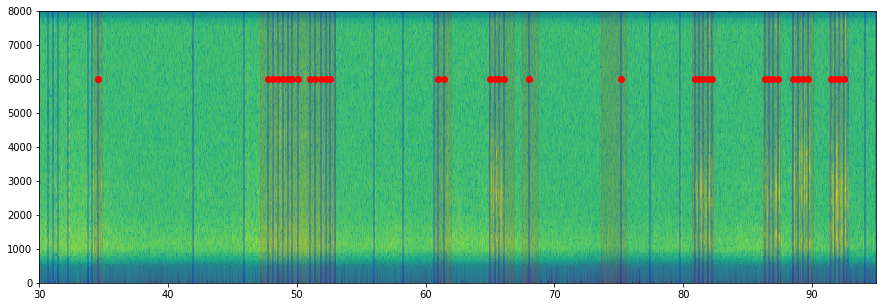

In [9]:
x_spacing = np.linspace(sample_start_s, sample_end_s, len(sample))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
for index, row in sheet_sample.iterrows():
    if row['Species'] == 'Storm Petrel':
        ax.axvspan(xmin=row['Time Start'], xmax=row['Time End'], color='red', alpha=0.1)
for onset in onsets[1:]:
    ax.axvline(x=onset, color='blue', alpha=0.3)
    if onset_in_call(onset, sheet_sample, buffer=0):
        plt.plot(onset, 6000, 'ro')
spec = plt.specgram(sample, Fs=sr, NFFT=win_s, noverlap=hop_s, xextent=(sample_start_s, sample_end_s))

In [10]:
sheet_sample

,Date,File Name,Type of Call,Time Start,Time End,Species,Notes
5,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,34.220,34.866,Storm Petrel,NaN
6,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,47.134,52.944,Storm Petrel,NaN
7,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,60.692,61.984,Storm Petrel,NaN
8,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,64.889,66.826,Storm Petrel,NaN
9,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,67.472,68.763,Storm Petrel,NaN
10,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,73.606,75.543,Storm Petrel,NaN
11,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,80.708,82.322,Storm Petrel,NaN
12,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,86.196,87.488,Storm Petrel,NaN
13,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,88.456,90.070,Storm Petrel,NaN
14,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,91.362,92.653,Storm Petrel,NaN


In [11]:
l = []
chunks_s = []

for onset, next_onset in zip(onsets, onsets[1:]):
    interval = next_onset - onset
    cut = next_onset if interval < max_duration_s else onset + max_duration_s
    l.append(cut - onset)
    chunks_s.append((onset, cut))

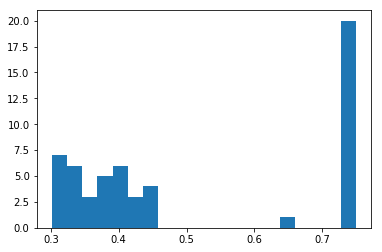

In [12]:
h = plt.hist(l, bins=20)

In [19]:
# sample *= 32767

for start, end in chunks_s[1:]:
    basename = os.path.basename(filename)
    dirname = os.path.dirname(filename)
    call = onset_in_call(start, sheet_sample, buffer=min_duration_s/2)
    if call:
        chunk_name = '{}_{:07.3f}_{:07.3f}_{}.wav'.format(os.path.splitext(basename)[0], start, end, call)
    else:
        chunk_name = '{}_{:07.3f}_{:07.3f}.wav'.format(os.path.splitext(basename)[0], start, end)
    # chunk_name_highpass = '{}_{:07.3f}_{:07.3f}_highpass.wav'.format(os.path.splitext(basename)[0], start, end)
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    chunk_path_out = os.path.join(dirname, chunk_name)
    # chunk_path_out_highpass = os.path.join(dirname, chunk_name_highpass)
    wavfile.write(chunk_path_out, sr, signal[start_sample: end_sample])
    # wavfile.write(chunk_path_out_highpass, sr, sample[start_sample: end_sample])

In [14]:
chunks = [(int(start*sr), int(end*sr)) for start, end in chunks_s]

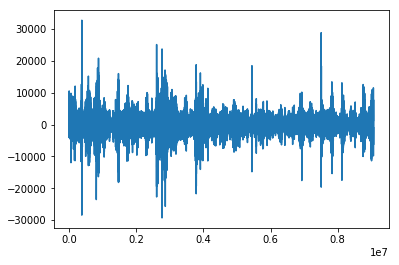

In [15]:
plt.plot(signal)

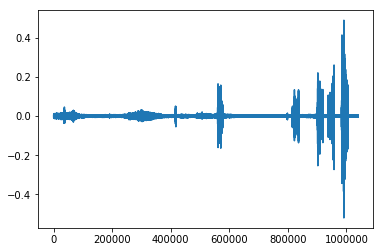

In [16]:
plt.plot(sample)